<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/version2/modeling/where_modeling/CA_KNN_MergeSupetSetData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

This colab is for KNN similarity 
* to find the counties from Oregon, that are similar to CA widespread counties


# Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')

In [ ]:
#drive.flush_and_unmount(600000)

In [ ]:
!ls '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021'

 All_CovidDataFeb20.csv
 alldatasets_Feb20.csv
 All_GoogleMobilityDataFeb20.csv
 All_SocialDistancingDataFeb20.csv
 AllStates_Superset_dataset_Feb20.csv
 AllStates_Superset_dataset_Feb21.csv
 CA_alldatasets_Feb05.csv
 CA_alldatasets_Jan13.csv
 CA_CombinedData_Labeled_CDCGuideline_Feb05.csv
 CA_CombinedData_Labeled_CDCGuideline_Feb06.csv
 CA_CombinedData_Labeled_CDCGuideline_Jan15.csv
 CA_combined_Feb04.csv
 CA_CovidDataJan10.csv
 CA_dataset_Feb11.csv
 CA_GoogleMobilityDataJan10.csv
 CA_MarylandData_Labeled_CDCGuideline_Feb05.csv
 CA_MarylandData_Labeled_CDCGuideline_Feb06.csv
 CA_MarylandData_Labeled_CDCGuideline_Jan15.csv
 CA_processedMarylandData_Feb04.csv
 CA_processedMarylandData_Feb05.csv
 CA_processedMarylandData_Feb12.csv
 CA_processedMarylandData_Jan11.csv
 CA_SocialDistancingDataJan10.csv
 CA_socialDistancingInertiaData_Feb04.csv
 CA_SuperData_Labeled_CDCGuideline_Feb13.csv
 CA_SuperData_Labeled_Guideline_Feb26.csv
 CA_Superset_bins_dataset_Feb20.csv
 CA_Superset_dataset_Feb12

# Import package

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler as ss
import itertools
from scipy import linalg
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import numpy as np
import matplotlib.pyplot as plt

# Load Oregon Binning Superset Data

In [ ]:
or_bin_superset_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/OR_Superset_bins_dataset_Mar04.csv',low_memory=False)



In [ ]:
print(or_bin_superset_data.shape)


(638, 60)


In [ ]:
or_bin_superset_data.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k
0,2020-02-29,Oregon,41031.0,0.0,Jefferson County,0.0,9.719966,92.366460,12.571429,8.857143,0.0,2.785714,0.285714,-0.928571,5.013675,Oregon,OR,41031.0,Jefferson County,41.0,20.571429,20.071429,3.756429,30.65000,1.528571,40.892857,0.534286,3.220714,0.0,24192.0,10.514286,1.08,26.0,50339.0,0.9,20.0,51.89,4.0,102.0,2.2,0.2,0.024,0.0,0.002143,43.5,48.812683,5.992857,0.035714,0.025714,0.214286,0.0000,0.061429,0.0000,1.00000,3.30000,7.25000,0.6,0.000,0.0,0.433903
1,2020-03-15,Oregon,41031.0,0.0,Jefferson County,0.0,4.678473,39.923913,-23.750000,4.187500,0.0,-6.500000,-27.750000,0.000000,5.013675,Oregon,OR,41031.0,Jefferson County,41.0,32.812500,25.000000,3.389375,27.61875,1.418750,34.625000,0.463750,2.923750,0.0,24192.0,0.325000,1.08,26.0,50339.0,0.9,20.0,51.89,4.0,102.0,2.2,0.2,0.024,0.0,0.055000,58.5,49.306294,5.418750,1.125000,1.244375,9.562500,0.8125,0.046250,3.0625,8.46875,6.64375,23.13125,0.6,3.675,0.0,0.000000


In [ ]:
print(or_bin_superset_data['County Name'].nunique())
or_bin_superset_data['County Name'].unique()

32


array(['Jefferson County', 'Lake County', 'Lincoln County',
       'Benton County', 'Jackson County', 'Marion County', 'Polk County',
       'Union County', 'Washington County', 'Douglas County',
       'Grant County', 'Columbia County', 'Linn County', 'Baker County',
       'Clackamas County', 'Clatsop County', 'Coos County',
       'Crook County', 'Curry County', 'Deschutes County',
       'Hood River County', 'Josephine County', 'Klamath County',
       'Lane County', 'Malheur County', 'Morrow County',
       'Multnomah County', 'Sherman County', 'Tillamook County',
       'Umatilla County', 'Wasco County', 'Yamhill County'], dtype=object)

In [ ]:
or_bin_superset_data['positivity_rate'] = (or_bin_superset_data['New.cases.1000.people'] / or_bin_superset_data['Tests.done.1000.people'])* 100/1000
or_bin_superset_data.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate
0,2020-02-29,Oregon,41031.0,0.0,Jefferson County,0.0,9.719966,92.366460,12.571429,8.857143,0.0,2.785714,0.285714,-0.928571,5.013675,Oregon,OR,41031.0,Jefferson County,41.0,20.571429,20.071429,3.756429,30.65000,1.528571,40.892857,0.534286,3.220714,0.0,24192.0,10.514286,1.08,26.0,50339.0,0.9,20.0,51.89,4.0,102.0,2.2,0.2,0.024,0.0,0.002143,43.5,48.812683,5.992857,0.035714,0.025714,0.214286,0.0000,0.061429,0.0000,1.00000,3.30000,7.25000,0.6,0.000,0.0,0.433903,0.0
1,2020-03-15,Oregon,41031.0,0.0,Jefferson County,0.0,4.678473,39.923913,-23.750000,4.187500,0.0,-6.500000,-27.750000,0.000000,5.013675,Oregon,OR,41031.0,Jefferson County,41.0,32.812500,25.000000,3.389375,27.61875,1.418750,34.625000,0.463750,2.923750,0.0,24192.0,0.325000,1.08,26.0,50339.0,0.9,20.0,51.89,4.0,102.0,2.2,0.2,0.024,0.0,0.055000,58.5,49.306294,5.418750,1.125000,1.244375,9.562500,0.8125,0.046250,3.0625,8.46875,6.64375,23.13125,0.6,3.675,0.0,0.000000,0.0


#  Load CA Superset Labeled Data

In [ ]:
ca_labeled_superset_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/CA_SuperData_Labeled_Guideline_Feb26.csv',low_memory=False)
ca_labeled_superset_data.head()

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,positivity_rate,rolling_avg_new_cases/100k,daily_growth_range,growth_label
0,2020-03-01,California,6001,0,Alameda County,0.0,3.684,58,6.0,9.0,15.0,1.0,4.0,0.0,860.757075,California,CA,6001,Alameda County,6,37,26,2.93,25.4,0.4,36.8,0.25,2.68,0,1666753,-5.1,15.04,19,92574,10.5,22.5,49.11,1155,131,2.05,0.22,0.0,0.0000,0.0,37,54.0,0.0,0.00,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.00,0.000000,0.000,0.0,0.0,minimal
1,2020-03-02,California,6001,0,Alameda County,0.0,6.182,98,4.0,7.0,7.0,-1.0,3.0,0.0,860.757075,California,CA,6001,Alameda County,6,17,20,3.38,28.2,0.4,38.1,0.63,2.74,0,1666753,-2.9,15.04,19,92574,10.5,22.5,49.11,1155,131,2.05,0.22,0.0,0.0000,0.0,38,54.0,0.0,0.00,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.00,0.000000,0.000,0.0,0.0,minimal
2,2020-03-03,California,6001,1,Alameda County,0.0,6.271,100,5.0,12.0,41.0,0.0,1.0,-1.0,860.757075,California,CA,6001,Alameda County,6,16,18,3.61,27.1,0.3,32.7,0.67,2.94,1,1666753,4.1,15.04,19,92574,10.5,22.5,49.11,1155,131,2.05,0.22,0.0,0.0002,0.0,0,54.0,0.0,0.00,0.0,0,1,0.05,42,1.1,5.3,5.7,0.6,0.00,0.059997,0.000,0.0,0.0,minimal
3,2020-03-04,California,6001,0,Alameda County,0.0,6.209,99,1.0,6.0,23.0,-3.0,1.0,0.0,860.757075,California,CA,6001,Alameda County,6,14,18,3.55,27.9,0.3,36.9,0.68,2.87,0,1666753,1.7,15.04,19,92574,10.5,22.5,49.11,1155,131,2.05,0.22,0.0,0.0002,0.0,0,54.0,10.3,0.01,0.0,0,1,0.06,42,1.1,5.3,5.7,0.6,0.04,0.000000,0.002,0.0,0.0,minimal
4,2020-03-05,California,6001,0,Alameda County,0.0,6.654,106,1.0,6.0,12.0,-5.0,-1.0,1.0,860.757075,California,CA,6001,Alameda County,6,15,19,3.54,28.1,0.3,36.8,0.66,2.88,0,1666753,2.0,15.04,19,92574,10.5,22.5,49.11,1155,131,2.05,0.22,0.0,0.0002,0.0,0,54.0,10.3,0.01,0.0,0,1,0.06,42,1.1,5.3,5.7,0.6,0.04,0.000000,0.002,0.0,0.0,minimal


In [ ]:
ca_labeled_superset_data['State'].unique()

array(['CA'], dtype=object)

In [ ]:
ca_labeled_superset_data.shape

(15391, 63)

In [ ]:
ca_labeled_superset_data.growth_label.unique()

array(['minimal', 'nochange', 'widespread'], dtype=object)

In [ ]:
#ca_labeled_superset_data = ca_labeled_superset_data[ca_labeled_superset_data['growth_label']=='widespread']

In [ ]:
ca_labeled_superset_data.shape

(15391, 63)

In [ ]:
print("CA labeled:", ca_labeled_superset_data.Date.min(),ca_labeled_superset_data.Date.max())
print("Oregon Bining:", or_bin_superset_data.Date.min(),or_bin_superset_data.Date.max())

CA labeled: 2020-03-01 2020-12-28
Oregon Bining: 2020-02-29 2020-12-15


# Filtering widespread data from CA

In [ ]:
ca_widespread_data = ca_labeled_superset_data[ca_labeled_superset_data['growth_label']=='widespread']
print(ca_widespread_data.shape)
ca_widespread_data.head(2)

# Column Mapping

In [ ]:
ca_labeled_superset_data.columns

Index(['Date', 'Province_State', 'FIPS', 'New cases', 'County Name',
       'mask_rule_severity', 'm50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'PopDensity', 'State_Name',
       'State', 'CTFIPS', 'CTNAME', 'STFIPS', 'Social.distancing.index',
       'X..staying.home', 'Trips.person', 'X..out.of.county.trips',
       'X..out.of.state.trips', 'Miles.person', 'Work.trips.person',
       'Non.work.trips.person', 'New.COVID.cases', 'Population',
       'X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Employment.density',
       'X..hot.spots.1000.people', 'Hospital.beds.1000.peop

'Province_State', 'FIPS', 'County Name','PopDensity', 'State_Name','State', 'CTFIPS', 'CTNAME', 'STFIPS',
'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Employment.density','Testing.capacity', 'Ventilator.shortage','Unemployment.rate','Unemployment.claims.1000.people',

In [ ]:
or_bin_superset_data.columns

Index(['Date', 'Province_State', 'FIPS', 'New cases', 'County Name',
       'mask_rule_severity', 'm50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'PopDensity', 'State_Name',
       'State', 'CTFIPS', 'CTNAME', 'STFIPS', 'Social.distancing.index',
       'X..staying.home', 'Trips.person', 'X..out.of.county.trips',
       'X..out.of.state.trips', 'Miles.person', 'Work.trips.person',
       'Non.work.trips.person', 'New.COVID.cases', 'Population',
       'X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Employment.density',
       'X..hot.spots.1000.people', 'Hospital.beds.1000.peop

In [ ]:
required_cols = [ 'mask_rule_severity', 'm50_index', #'FIPS',
        'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'PopDensity',
        'Social.distancing.index','X..staying.home', 'Trips.person', 'X..out.of.county.trips',
       'X..out.of.state.trips', 'Miles.person', 'Work.trips.person',
       'Non.work.trips.person',#'Population',
       'X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male','Employment.density',
       'X..hot.spots.1000.people', 'Hospital.beds.1000.people',
       'ICUs.1000.people','X.days..decreasing.COVID.cases', 'X..hospital.bed.utilization',
       'Testing.capacity', 'Tests.done.1000.people', 'X..ICU.utilization',
       'Ventilator.shortage', 'Imported.COVID.cases',
       'COVID.exposure.1000.people', 'X.days..decreasing.ILI.cases',
       'Unemployment.claims.1000.people', 'Unemployment.rate',
       'X..working.from.home', 'Cumulative.inflation.rate', 'COVID.death.rate',
       'rolling_avg_new_cases/100k']

## Important columns from PCA

In [ ]:
important_cols = ['Tests.done.1000.people',
 'X..staying.home',
 'Unemployment.rate',
 'X..people.older.than.60',
 'X..working.from.home',
 'X.days..decreasing.ILI.cases',
 'X..Male',
 'positivity_rate',
 'X..out.of.county.trips',
 'parks_percent_change_from_baseline',#mobility
 'Work.trips.person',
 'm50_index',#Social distancing
 'Imported.COVID.cases',
 'X..out.of.state.trips',
 'Miles.person',
 'X.days..decreasing.COVID.cases',
 'grocery_and_pharmacy_percent_change_from_baseline',#mobility
 'New Cases/100k population',
 'transit_stations_percent_change_from_baseline',#mobility
 'Testing.capacity',
 'retail_and_recreation_percent_change_from_baseline',#mobility
 'Unemployment.claims.1000.people']

**Summary**: The latent features (loc2vec features ) describe the probalistic causal behaviour of the pandemic. The features are responsible for describing the sudden increase or surge of the pandemic. The counties with closest 

* Surge in LA -> Surge in WA county in OR


In [ ]:
ca_labeled_superset_data_filtered = ca_labeled_superset_data[required_cols]


NameError: ignored

In [ ]:
or_bin_superset_data_filtered = or_bin_superset_data[required_cols]

### Updated to select PCA important columns 

In [ ]:

ca_labeled_superset_data_filtered = ca_labeled_superset_data[important_cols]
or_bin_superset_data_filtered = or_bin_superset_data[important_cols]

In [ ]:
print(ca_labeled_superset_data_filtered.shape)
print(or_bin_superset_data_filtered.shape)

(15391, 22)
(638, 22)


# Use these columns

In [ ]:
x_col_all_group = [ 'FIPS','mask_rule_severity', 'm50_index',
        'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'PopDensity',
        'Social.distancing.index','X..staying.home', 'Trips.person', 'X..out.of.county.trips',
       'X..out.of.state.trips', 'Miles.person', 'Work.trips.person',
       'Non.work.trips.person','Population',
       'X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male','Employment.density',
       'X..hot.spots.1000.people', 'Hospital.beds.1000.people',
       'ICUs.1000.people','X.days..decreasing.COVID.cases', 'X..hospital.bed.utilization',
       'Testing.capacity', 'Tests.done.1000.people', 'X..ICU.utilization',
       'Ventilator.shortage', 'Imported.COVID.cases',
       'COVID.exposure.1000.people', 'X.days..decreasing.ILI.cases',
       'Unemployment.claims.1000.people', 'Unemployment.rate',
       'X..working.from.home', 'Cumulative.inflation.rate', 'COVID.death.rate',
       'rolling_avg_new_cases/100k']


# Remove FIPS ,

In [ ]:
len(x_col_all_group)

45

# KNN Similarity between CA data and OR binning reduced data



In [ ]:
#https://towardsdatascience.com/cosine-similarity-how-does-it-measure-the-similarity-maths-behind-and-usage-in-python-50ad30aad7db
#### Reference Code 
# using sklearn to calculate cosine similarity
#from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
#cos_sim=cosine_similarity(A.reshape(1,-1),B.reshape(1,-1))
#print (f"Cosine Similarity between A and B:{cos_sim}")- high is good
#print (f"Cosine Distance between A and B:{1-cos_sim}")- distance less is good

In [ ]:
or_bin_superset_data_filtered.describe().T

,count,mean,std,min,25%,50%,75%,max
Tests.done.1000.people,638.0,134.736406,152.547427,0.035436,18.920245,85.068333,188.204375,602.726667
X..staying.home,638.0,26.267425,4.020645,16.375000,23.317708,25.861905,28.796429,40.400000
Unemployment.rate,638.0,9.103396,2.980959,3.300000,6.735425,7.900000,11.509416,14.619313
X..people.older.than.60,638.0,27.757053,6.047606,18.000000,22.250000,27.000000,33.000000,43.000000
X..working.from.home,638.0,31.298635,6.644006,7.247692,29.956818,32.658571,33.776515,38.450000
X.days..decreasing.ILI.cases,638.0,65.940807,58.171010,0.000000,18.915909,35.000000,109.280769,175.000000
X..Male,638.0,50.183386,1.527385,48.140000,49.247500,49.700000,50.480000,54.490000
positivity_rate,638.0,0.000147,0.000526,0.000000,0.000018,0.000043,0.000108,0.009940
X..out.of.county.trips,638.0,28.344217,12.040692,7.113333,18.676667,28.025833,36.771667,75.200000
parks_percent_change_from_baseline,638.0,24.009202,35.354196,-24.733333,0.000000,11.273810,33.196875,176.866667


In [ ]:
ca_labeled_superset_data_filtered.describe().T

,count,mean,std,min,25%,50%,75%,max
Tests.done.1000.people,15391.0,233.967335,221.686124,0.000000,26.940000,178.160000,401.410000,812.210000
X..staying.home,15391.0,26.896498,5.921109,13.000000,23.000000,26.000000,30.000000,61.000000
Unemployment.rate,15391.0,11.928374,3.167767,5.300000,9.700000,11.400000,14.900000,17.000000
X..people.older.than.60,15391.0,22.703008,6.106907,14.000000,18.000000,21.000000,26.000000,38.000000
X..working.from.home,15391.0,35.345260,7.158810,5.700000,34.400000,36.900000,38.100000,42.300000
X.days..decreasing.ILI.cases,15391.0,120.561822,81.906428,0.000000,42.000000,119.000000,196.000000,266.000000
X..Male,15391.0,50.421286,2.449918,48.180000,49.470000,49.840000,50.730000,66.290000
positivity_rate,15391.0,0.000299,0.001561,0.000000,0.000015,0.000042,0.000109,0.048667
X..out.of.county.trips,15391.0,23.440465,10.294389,2.100000,15.100000,22.400000,30.900000,100.000000
parks_percent_change_from_baseline,15391.0,5.290689,37.515584,-83.000000,-13.000000,0.000000,16.000000,323.000000


In [ ]:
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from tqdm import tqdm

def key_consine_similarity(tupple):
    return tupple[1]

# This method computes the distance between each vectors with predicted_vectors input
# in our case, vectors is CA data , predicted_vectors is OR data

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(vectors) # size of your CA data
    #print("len of OR:", len(predicted_vectors)) #size of OR
    #print("len of CA:", data_size)
    cosine_similarities = []
    simiarity_ids = []

    for i in range(len(predicted_vectors)): #OR
      max_cosine = 0
      max_j = -1
      #print('actual : ',predicted_vectors[i],' reshaped : ',predicted_vectors[i].reshape(1,-1))
      for j in range(data_size): #CA
        ##cosine_sim_val = (1 - cosine(vectors[j], predicted_vectors[i]))
        # if i == 31:
        #   print(vectors[j].reshape(1,-1))
        #   print(predicted_vectors[i].reshape(1,-1))
        cosine_sim_val = cosine_similarity(vectors[j].reshape(1,-1), predicted_vectors[i].reshape(1,-1)) 
        if max_cosine < cosine_sim_val:
            max_cosine = cosine_sim_val
            max_j = j
      cosine_similarities.append((max_j, max_cosine))
      simiarity_ids.append(max_j)
        #if cosine_sim_val > 0.5: # update threshold
          #continue
      #if i > 50: break
        
    #print('len cosine_similarities : ',len(cosine_similarities))
    #return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)
    return cosine_similarities,simiarity_ids

def display_top_n(sorted_cosine_similarities, n=10):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        print('News Title: ', merged_data.iloc[index, 0])  
        print('News statement: ', merged_data.iloc[index, 1])  
        print('News label: ', merged_data.iloc[index, 4])  

        print('Cosine Sim Val :', consine_sim_val)
        print('---------------------------------')

In [ ]:
or_bin_superset_data_filtered.values[31].reshape(1,-1)

array([[145.625     ,  30.5       ,   7.9       ,  33.        ,
         33.        , 175.        ,  53.45      ,   0.        ,
         24.35      ,   0.        ,   0.235     , 162.9       ,
          6.        ,   4.2       ,  28.45      ,   2.5       ,
          0.        ,  -6.34598299,   0.        ,   4.8       ,
          0.        ,   1.35      ]])

In [ ]:
or_bin_superset_data[or_bin_superset_data.index == 31]

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate
31,2020-08-15,Oregon,NaN,NaN,Lake County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oregon,OR,NaN,Lake County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
%%time
cosine_similarities,simiarity_ids = get_computed_similarities(vectors=ca_labeled_superset_data_filtered.values, predicted_vectors=or_bin_superset_data_filtered.values)

CPU times: user 25min 27s, sys: 1.12 s, total: 25min 28s
Wall time: 25min 27s


In [ ]:
cosine_similarities

[(301, array([[0.99477784]])),
 (13669, array([[0.98887557]])),
 (2570, array([[0.9737712]])),
 (2590, array([[0.9860505]])),
 (2605, array([[0.98581796]])),
 (6539, array([[0.98761495]])),
 (6539, array([[0.97453799]])),
 (3496, array([[0.97680398]])),
 (1805, array([[0.96842774]])),
 (2659, array([[0.96959079]])),
 (412, array([[0.96928772]])),
 (405, array([[0.96894417]])),
 (4367, array([[0.97031997]])),
 (8302, array([[0.97474313]])),
 (6719, array([[0.91098591]])),
 (6718, array([[0.9386893]])),
 (6721, array([[0.95600676]])),
 (6717, array([[0.96852179]])),
 (6722, array([[0.99178197]])),
 (3659, array([[0.99552093]])),
 (14240, array([[0.99152189]])),
 (13380, array([[0.95923076]])),
 (4584, array([[0.96815695]])),
 (4588, array([[0.98696219]])),
 (4603, array([[0.98934772]])),
 (8269, array([[0.97065684]])),
 (3491, array([[0.97889853]])),
 (8283, array([[0.98737189]])),
 (8283, array([[0.99206566]])),
 (8288, array([[0.99219017]])),
 (8288, array([[0.99060739]])),
 (8298, arr

In [ ]:
or_bin_superset_data['FIPS'].unique()

array([41067])

In [ ]:
#print("CA row number=",or_bin_superset_data.iloc[0]['similiary_score'][0])
growth_labels = []
for id in simiarity_ids:
  growth_label = ca_labeled_superset_data.iloc[id]['growth_label']
  growth_labels.append(growth_label)

print('length: ',len(growth_labels))
or_bin_superset_data['growth_label']= growth_labels
or_bin_superset_data.head(2)

length:  638


,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate,growth_label
0,2020-02-29,Oregon,41031.0,0.0,Jefferson County,0.0,9.719966,92.366460,12.571429,8.857143,0.0,2.785714,0.285714,-0.928571,5.013675,Oregon,OR,41031.0,Jefferson County,41.0,20.571429,20.071429,3.756429,30.65000,1.528571,40.892857,0.534286,3.220714,0.0,24192.0,10.514286,1.08,26.0,50339.0,0.9,20.0,51.89,4.0,102.0,2.2,0.2,0.024,0.0,0.002143,43.5,48.812683,5.992857,0.035714,0.025714,0.214286,0.0000,0.061429,0.0000,1.00000,3.30000,7.25000,0.6,0.000,0.0,0.433903,0.0,nochange
1,2020-03-15,Oregon,41031.0,0.0,Jefferson County,0.0,4.678473,39.923913,-23.750000,4.187500,0.0,-6.500000,-27.750000,0.000000,5.013675,Oregon,OR,41031.0,Jefferson County,41.0,32.812500,25.000000,3.389375,27.61875,1.418750,34.625000,0.463750,2.923750,0.0,24192.0,0.325000,1.08,26.0,50339.0,0.9,20.0,51.89,4.0,102.0,2.2,0.2,0.024,0.0,0.055000,58.5,49.306294,5.418750,1.125000,1.244375,9.562500,0.8125,0.046250,3.0625,8.46875,6.64375,23.13125,0.6,3.675,0.0,0.000000,0.0,nochange


In [ ]:
or_bin_superset_data.to_csv("OR_testdata_labeled.csv",index=False)

In [ ]:
or_bin_superset_data.tail()

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate,growth_label
633,2020-10-15,Oregon,41071.0,7.437500,Yamhill County,10.0,3.959063,63.750000,-7.250000,-6.750000,42.500000,-24.312500,-25.875000,6.375000,55.992733,Oregon,OR,41071.0,Yamhill County,41.0,26.250000,23.687500,3.872500,29.043750,1.031250,45.168750,0.471875,3.401250,7.437500,107002.0,9.518750,0.74,23.0,59484.0,0.8,15.8,49.98,42.0,130.0,2.2,0.2,0.024,0.066988,2.283125,3.562500,51.267599,5.075000,193.502500,6.368750,18.312500,173.312500,6.616875,20.562500,1.018750,6.543750,32.456250,1.71,2.319375,6.950805,7.226167,0.000035,minimal
634,2020-10-31,Oregon,41071.0,20.200000,Yamhill County,10.0,2.974067,47.800000,-11.666667,-8.266667,24.800000,-35.866667,-25.466667,7.466667,55.992733,Oregon,OR,41071.0,Yamhill County,41.0,30.666667,26.133333,3.701333,28.340000,0.993333,40.780000,0.460000,3.242000,20.200000,107002.0,4.386667,0.74,23.0,59484.0,0.8,15.8,49.98,42.0,130.0,2.2,0.2,0.024,0.174860,3.231333,0.133333,52.358385,5.500000,215.649333,8.004000,25.400000,227.733333,8.222667,21.933333,1.046667,6.120000,32.360000,1.71,2.118667,18.878152,14.944091,0.000081,minimal
635,2020-11-15,Oregon,41071.0,26.733333,Yamhill County,10.0,2.319333,37.266667,-24.133333,-10.466667,17.266667,-28.333333,-35.066667,10.866667,55.992733,Oregon,OR,41071.0,Yamhill County,41.0,41.666667,29.933333,3.059333,30.873333,1.346667,37.860000,0.446667,2.611333,26.733333,107002.0,-15.920000,0.74,23.0,59484.0,0.8,15.8,49.98,42.0,130.0,2.2,0.2,0.024,0.246727,5.564000,0.333333,53.096547,6.466667,239.664000,12.823333,28.333333,356.066667,11.060667,8.866667,3.000000,6.513333,33.393333,1.71,1.791333,24.983957,24.921653,0.000103,widespread
636,2020-11-30,Oregon,41071.0,30.909091,Yamhill County,10.0,3.201909,51.454545,-20.181818,-7.272727,25.818182,-40.727273,-31.000000,9.727273,55.992733,Oregon,OR,41071.0,Yamhill County,41.0,32.181818,27.181818,3.538182,28.790909,1.027273,41.518182,0.524545,3.016364,30.909091,107002.0,-2.872727,0.74,23.0,59484.0,0.8,15.8,49.98,42.0,130.0,2.2,0.2,0.024,0.285745,8.178182,1.090909,56.199808,4.572727,460.649091,15.123636,53.545455,543.272727,15.441818,22.272727,3.700000,7.718182,33.772727,1.71,1.584545,28.886461,26.823142,0.000062,minimal
637,2020-12-15,Oregon,41071.0,26.100000,Yamhill County,10.0,2.338600,37.600000,-22.100000,-4.500000,14.300000,-18.200000,-39.400000,10.900000,55.992733,Oregon,OR,41071.0,Yamhill County,41.0,37.000000,28.800000,3.247000,31.530000,1.230000,40.550000,0.411000,2.833000,26.100000,107002.0,-8.780000,0.74,23.0,59484.0,0.8,15.8,49.98,42.0,130.0,2.2,0.2,0.024,0.242050,9.322000,8.500000,57.586805,4.240000,598.030000,13.975000,65.500000,638.600000,19.728000,35.000000,3.700000,9.530000,30.360000,1.71,1.678000,24.392067,28.624298,0.000040,nochange


In [ ]:
#or_bin_superset_data['growth_label'].unique()
print(or_bin_superset_data[or_bin_superset_data['growth_label'] == 'minimal'].shape)
print(or_bin_superset_data[or_bin_superset_data['growth_label'] == 'nochange'].shape)
print(or_bin_superset_data[or_bin_superset_data['growth_label'] == 'widespread'].shape)

(187, 62)
(313, 62)
(138, 62)


In [ ]:
or_bin_superset_data['County Name'].unique()

array(['Jefferson County', 'Lake County', 'Lincoln County',
       'Benton County', 'Jackson County', 'Marion County', 'Polk County',
       'Union County', 'Washington County', 'Douglas County',
       'Grant County', 'Columbia County', 'Linn County', 'Baker County',
       'Clackamas County', 'Clatsop County', 'Coos County',
       'Crook County', 'Curry County', 'Deschutes County',
       'Hood River County', 'Josephine County', 'Klamath County',
       'Lane County', 'Malheur County', 'Morrow County',
       'Multnomah County', 'Sherman County', 'Tillamook County',
       'Umatilla County', 'Wasco County', 'Yamhill County'], dtype=object)

In [ ]:
ws_data = or_bin_superset_data[or_bin_superset_data['growth_label'] == 'widespread']
print(ws_data['County Name'].nunique())
ws_data['County Name'].unique()

32


array(['Jefferson County', 'Lake County', 'Lincoln County',
       'Benton County', 'Jackson County', 'Marion County', 'Polk County',
       'Union County', 'Washington County', 'Douglas County',
       'Grant County', 'Columbia County', 'Linn County', 'Baker County',
       'Clackamas County', 'Clatsop County', 'Coos County',
       'Crook County', 'Curry County', 'Deschutes County',
       'Hood River County', 'Josephine County', 'Klamath County',
       'Lane County', 'Malheur County', 'Morrow County',
       'Multnomah County', 'Sherman County', 'Tillamook County',
       'Umatilla County', 'Wasco County', 'Yamhill County'], dtype=object)

In [ ]:
minimal_data = or_bin_superset_data[or_bin_superset_data['growth_label'] == 'minimal']
print(minimal_data['County Name'].nunique())
minimal_data['County Name'].unique()

31


array(['Jefferson County', 'Lake County', 'Lincoln County',
       'Benton County', 'Jackson County', 'Marion County', 'Polk County',
       'Union County', 'Washington County', 'Douglas County',
       'Grant County', 'Columbia County', 'Linn County', 'Baker County',
       'Clackamas County', 'Clatsop County', 'Coos County',
       'Crook County', 'Curry County', 'Deschutes County',
       'Hood River County', 'Josephine County', 'Klamath County',
       'Lane County', 'Malheur County', 'Morrow County',
       'Multnomah County', 'Sherman County', 'Tillamook County',
       'Wasco County', 'Yamhill County'], dtype=object)

In [ ]:
nochange_data = or_bin_superset_data[or_bin_superset_data['growth_label'] == 'nochange']
print(nochange_data['County Name'].nunique())
nochange_data['County Name'].unique()

32


array(['Jefferson County', 'Lake County', 'Lincoln County',
       'Benton County', 'Jackson County', 'Marion County', 'Polk County',
       'Union County', 'Washington County', 'Douglas County',
       'Grant County', 'Columbia County', 'Linn County', 'Baker County',
       'Clackamas County', 'Clatsop County', 'Coos County',
       'Crook County', 'Curry County', 'Deschutes County',
       'Hood River County', 'Josephine County', 'Klamath County',
       'Lane County', 'Malheur County', 'Morrow County',
       'Multnomah County', 'Sherman County', 'Tillamook County',
       'Umatilla County', 'Wasco County', 'Yamhill County'], dtype=object)

In [ ]:
print(ca_labeled_superset_data_filtered.shape)
ca_labeled_superset_data_filtered.head(2)

(15391, 29)


,Tests.done.1000.people,X..staying.home,Unemployment.rate,X..people.older.than.60,X..working.from.home,X.days..decreasing.ILI.cases,X..Male,positivity_rate,X..out.of.county.trips,positivity_rate,parks_percent_change_from_baseline,Work.trips.person,m50_index,FIPS,positivity_rate,positivity_rate,Imported.COVID.cases,X..out.of.state.trips,positivity_rate,Miles.person,X.days..decreasing.COVID.cases,grocery_and_pharmacy_percent_change_from_baseline,New Cases/100k population,transit_stations_percent_change_from_baseline,transit_stations_percent_change_from_baseline,Testing.capacity,Testing.capacity,retail_and_recreation_percent_change_from_baseline,Unemployment.claims.1000.people
0,0.0,26,5.3,19,5.7,35,49.11,0.0,25.4,0.0,15.0,0.25,58,6001,0.0,0.0,0,0.4,0.0,36.8,37,9.0,0.0,1.0,1.0,0.0,0.0,6.0,1.1
1,0.0,20,5.3,19,5.7,35,49.11,0.0,28.2,0.0,7.0,0.63,98,6001,0.0,0.0,0,0.4,0.0,38.1,38,7.0,0.0,-1.0,-1.0,0.0,0.0,4.0,1.1


In [ ]:
or_bin_superset_data.head(4)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,similiary_score
0,2020-10-02,Oregon,41067,65,Washington County,10.0,21.121,107,-21.0,-7.0,0.0,-43.0,-43.0,13.0,310.164459,Oregon,OR,41067,Washington County,41,28,26,3.52,28.5,2.6,35.9,0.37,3.16,65,597695,6.2,6.13,18,78010,1.9,16.5,49.42,354,132,2.2,0.2,0.024,0.0736,1.68,0,50.99648,4.9,166.39,5.73,15,636,5.51,0,0.9,7.2,32.9,1.71,2.44,10.875112,6.286054,"(10952, [[0.9999907527813767]])"
1,2020-10-02,Oregon,41067,65,Washington County,10.0,7.931,104,-21.0,-7.0,0.0,-43.0,-43.0,13.0,310.164459,Oregon,OR,41067,Washington County,41,28,26,3.52,28.5,2.6,35.9,0.37,3.16,65,597695,6.2,6.13,18,78010,1.9,16.5,49.42,354,132,2.2,0.2,0.024,0.0736,1.68,0,50.99648,4.9,166.39,5.73,15,636,5.51,0,0.9,7.2,32.9,1.71,2.44,10.875112,7.050897,"(10952, [[0.9999907971148785]])"
2,2020-10-02,Oregon,41067,65,Washington County,10.0,22.297,128,-21.0,-7.0,0.0,-43.0,-43.0,13.0,310.164459,Oregon,OR,41067,Washington County,41,28,26,3.52,28.5,2.6,35.9,0.37,3.16,65,597695,6.2,6.13,18,78010,1.9,16.5,49.42,354,132,2.2,0.2,0.024,0.0736,1.68,0,50.99648,4.9,166.39,5.73,15,636,5.51,0,0.9,7.2,32.9,1.71,2.44,10.875112,7.815740,"(10952, [[0.999990398846052]])"
3,2020-10-02,Oregon,41067,65,Washington County,10.0,15.267,192,-21.0,-7.0,0.0,-43.0,-43.0,13.0,310.164459,Oregon,OR,41067,Washington County,41,28,26,3.52,28.5,2.6,35.9,0.37,3.16,65,597695,6.2,6.13,18,78010,1.9,16.5,49.42,354,132,2.2,0.2,0.024,0.0736,1.68,0,50.99648,4.9,166.39,5.73,15,636,5.51,0,0.9,7.2,32.9,1.71,2.44,10.875112,8.580583,"(10952, [[0.9999888745768173]])"


In [ ]:
or_bin_superset_data['similiary_score'] = cosine_similarities


## Save Temp File to CSV [For Analysis]

In [ ]:
from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'
filename = 'OR_SuperData_With_SimilarityScore_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
or_bin_superset_data.to_csv(location+filename,index=False)

OR_SuperData_With_SimilarityScore_Mar04.csv


In [ ]:
df_washington_county = OR_labeled[OR_labeled['County Name'] == 'Washington County']
df_washington_county.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate,growth_label,similiary_score
159,2020-02-29,Oregon,41067.0,0.853846,Washington County,0.0,9.536064,94.343590,1.782051,2.456410,27.805128,-3.200000,-1.525641,1.258974,310.164459,Oregon,OR,41067.0,Washington County,41.0,22.943590,21.548718,3.536538,28.142564,2.236667,33.662564,0.565564,2.968846,0.853846,597695.0,-0.219487,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.001275,0.002103,0.000000,48.812293,5.981538,0.035436,0.024923,0.207692,1.202564,0.061359,0.00000,1.000000,3.30000,7.247692,0.6,0.000000,0.142856,0.304167,0.003598,nochange,"(12490, array([[0.99253199]]))"
160,2020-03-15,Oregon,41067.0,9.731982,Washington County,0.0,4.223745,41.497748,-37.288288,-12.495495,30.878378,-43.211712,-42.806306,16.842342,310.164459,Oregon,OR,41067.0,Washington County,41.0,53.364865,35.430180,2.848063,24.745495,2.106306,22.321396,0.400676,2.447410,9.731982,597695.0,-17.762162,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.015051,0.055293,0.184685,49.307290,5.414865,1.131869,1.247523,9.585586,15.752252,0.046261,3.09009,8.496396,6.66036,23.181081,0.6,3.694572,1.628252,1.615817,0.001330,minimal,"(11630, array([[0.96498917]]))"


In [ ]:

ca_labeled_superset_data.filter(like = '12490', axis=0)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,positivity_rate,rolling_avg_new_cases/100k,daily_growth_range,growth_label
12490,2020-03-10,California,6095,3,Solano County,0.0,7.261,101,3.0,6.0,31.0,-1.0,2.0,0.0,206.044406,California,CA,6095,Solano County,6,14,18,3.65,28.2,0.2,45.8,0.66,2.98,3,446610,0.3,2.99,21,77609,13.6,26.1,49.7,180,102,2.05,0.22,0.0,0.0022,0.0,0,54.028798,16.2,0.02,0.06,5,1,0.08,0,1.5,5.3,9.4,0.6,0.07,0.671727,0.011,0.095961,0.095961,nochange


In [ ]:
# use only demographic+ Pandemic behaviour related data(observed and latent variables) 
# and find the similar county in OR

# Notes for documentation
* use only demographic+ Pandemic behaviour related data(observed and latent variables) and find the similar county in OR
* Bayesian network to predict "What is the likelihood the related county will also spike?"

* Prob. of given the characteristics -> spike in cases
growth in cases / likelihood 

GNN - each county is represented as graph. each feature is a node and connected by a branch. Graph similarity 
Bayes rule - Professor share the resources 


In [ ]:
df_washington_county = or_bin_superset_data[or_bin_superset_data['County Name'] == 'Washington County']
print(df_washington_county.shape)
df_washington_county.head(2)

(20, 63)


,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate,growth_label,similiary_score
159,2020-02-29,Oregon,41067.0,0.853846,Washington County,0.000000,9.536064,94.343590,1.782051,2.456410,27.805128,-3.200000,-1.525641,1.258974,310.164459,Oregon,OR,41067.0,Washington County,41.0,22.943590,21.548718,3.536538,28.142564,2.236667,33.662564,0.565564,2.968846,0.853846,597695.0,-0.219487,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.001275,0.002103,0.000000,48.812293,5.981538,0.035436,0.024923,0.207692,1.202564,0.061359,0.000000,1.000000,3.300000,7.247692,0.600000,0.000000,0.142856,0.304167,0.003598,nochange,"(12490, [[0.9925319911759277]])"
160,2020-03-15,Oregon,41067.0,9.731982,Washington County,0.000000,4.223745,41.497748,-37.288288,-12.495495,30.878378,-43.211712,-42.806306,16.842342,310.164459,Oregon,OR,41067.0,Washington County,41.0,53.364865,35.430180,2.848063,24.745495,2.106306,22.321396,0.400676,2.447410,9.731982,597695.0,-17.762162,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.015051,0.055293,0.184685,49.307290,5.414865,1.131869,1.247523,9.585586,15.752252,0.046261,3.090090,8.496396,6.660360,23.181081,0.600000,3.694572,1.628252,1.615817,0.001330,minimal,"(11630, [[0.9649891678608176]])"
161,2020-03-31,Oregon,41067.0,13.184211,Washington County,0.000000,2.823955,27.174641,-45.083732,-19.947368,31.401914,-49.866029,-53.511962,20.653110,310.164459,Oregon,OR,41067.0,Washington County,41.0,60.165072,38.282297,2.737010,23.539474,1.959091,18.009569,0.367751,2.364593,13.184211,597695.0,-20.538038,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.022715,0.263660,1.126794,50.131729,5.160287,5.409474,5.623684,25.916268,70.313397,0.060622,18.169856,11.880861,13.081100,26.307895,0.226794,12.977584,2.205843,2.216650,0.000420,minimal,"(14847, [[0.9707145472255994]])"
162,2020-04-15,Oregon,41067.0,7.642857,Washington County,0.000000,3.826957,36.719388,-41.428571,-16.642857,16.357143,-44.642857,-51.142857,19.357143,310.164459,Oregon,OR,41067.0,Washington County,41.0,56.642857,35.642857,2.786429,24.857143,2.164286,19.357143,0.349286,2.437143,7.785714,597695.0,-18.121429,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.013421,0.420714,2.285714,50.062779,4.814286,10.334286,8.497143,25.785714,116.857143,0.092857,33.500000,10.242857,14.614286,28.185714,0.200000,20.927857,1.278722,1.276161,0.000130,nochange,"(7939, [[0.9868004562155274]])"
163,2020-04-30,Oregon,41067.0,9.000000,Washington County,0.000000,5.958569,60.173810,-36.266667,-8.600000,15.200000,-44.200000,-48.533333,18.200000,310.164459,Oregon,OR,41067.0,Washington County,41.0,50.133333,32.133333,2.938000,25.986667,2.433333,22.213333,0.340667,2.597333,9.000000,597695.0,-12.706667,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.0

In [ ]:
df_washington_county = OR_labeled[OR_labeled['County Name'] == 'Washington County']
print(df_washington_county.shape)
df_washington_county.head(2)

(20, 63)


,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate,growth_label,similiary_score
159,2020-02-29,Oregon,41067.0,0.853846,Washington County,0.0,9.536064,94.343590,1.782051,2.456410,27.805128,-3.200000,-1.525641,1.258974,310.164459,Oregon,OR,41067.0,Washington County,41.0,22.943590,21.548718,3.536538,28.142564,2.236667,33.662564,0.565564,2.968846,0.853846,597695.0,-0.219487,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.001275,0.002103,0.000000,48.812293,5.981538,0.035436,0.024923,0.207692,1.202564,0.061359,0.00000,1.000000,3.30000,7.247692,0.6,0.000000,0.142856,0.304167,0.003598,nochange,"(12490, array([[0.99253199]]))"
160,2020-03-15,Oregon,41067.0,9.731982,Washington County,0.0,4.223745,41.497748,-37.288288,-12.495495,30.878378,-43.211712,-42.806306,16.842342,310.164459,Oregon,OR,41067.0,Washington County,41.0,53.364865,35.430180,2.848063,24.745495,2.106306,22.321396,0.400676,2.447410,9.731982,597695.0,-17.762162,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.015051,0.055293,0.184685,49.307290,5.414865,1.131869,1.247523,9.585586,15.752252,0.046261,3.09009,8.496396,6.66036,23.181081,0.6,3.694572,1.628252,1.615817,0.001330,minimal,"(11630, array([[0.96498917]]))"


## Visualization

In [ ]:
df_solano_county = ca_labeled_superset_data[ca_labeled_superset_data['County Name'] == 'Solano County']
print(df_solano_county.shape)
df_solano_county.head(2)

(292, 63)


,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,positivity_rate,rolling_avg_new_cases/100k,daily_growth_range,growth_label
12481,2020-03-01,California,6095,0,Solano County,0.0,3.327,46,7.0,5.0,17.0,6.0,2.0,-1.0,206.044406,California,CA,6095,Solano County,6,41,26,2.95,28.6,0.2,37.5,0.24,2.71,0,446610,-8.8,2.99,21,77609,13.6,26.1,49.7,180,102,2.05,0.22,0.0,0.0,0.0,37,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,nochange
12482,2020-03-02,California,6095,0,Solano County,0.0,6.810,95,7.0,5.0,11.0,7.0,3.0,-1.0,206.044406,California,CA,6095,Solano County,6,16,18,3.61,27.3,0.2,44.6,0.61,3.00,0,446610,1.0,2.99,21,77609,13.6,26.1,49.7,180,102,2.05,0.22,0.0,0.0,0.0,38,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,nochange


In [ ]:
df_solano_county.index = pd.to_datetime(df_solano_county["Date"])

df_solano_county.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,positivity_rate,rolling_avg_new_cases/100k,daily_growth_range,growth_label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-01,2020-03-01,California,6095,0,Solano County,0.0,3.327,46,7.0,5.0,17.0,6.0,2.0,-1.0,206.044406,California,CA,6095,Solano County,6,41,26,2.95,28.6,0.2,37.5,0.24,2.71,0,446610,-8.8,2.99,21,77609,13.6,26.1,49.7,180,102,2.05,0.22,0.0,0.0,0.0,37,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,nochange
2020-03-02,2020-03-02,California,6095,0,Solano County,0.0,6.810,95,7.0,5.0,11.0,7.0,3.0,-1.0,206.044406,California,CA,6095,Solano County,6,16,18,3.61,27.3,0.2,44.6,0.61,3.00,0,446610,1.0,2.99,21,77609,13.6,26.1,49.7,180,102,2.05,0.22,0.0,0.0,0.0,38,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,nochange


## Merging Solano and Washington county

In [ ]:
df_washington_county.index = pd.to_datetime(df_washington_county["Date"])

df_washington_county.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate,growth_label,similiary_score
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-29,2020-02-29,Oregon,41067.0,0.853846,Washington County,0.0,9.536064,94.343590,1.782051,2.456410,27.805128,-3.200000,-1.525641,1.258974,310.164459,Oregon,OR,41067.0,Washington County,41.0,22.943590,21.548718,3.536538,28.142564,2.236667,33.662564,0.565564,2.968846,0.853846,597695.0,-0.219487,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.001275,0.002103,0.000000,48.812293,5.981538,0.035436,0.024923,0.207692,1.202564,0.061359,0.00000,1.000000,3.30000,7.247692,0.6,0.000000,0.142856,0.304167,0.003598,nochange,"(12490, array([[0.99253199]]))"
2020-03-15,2020-03-15,Oregon,41067.0,9.731982,Washington County,0.0,4.223745,41.497748,-37.288288,-12.495495,30.878378,-43.211712,-42.806306,16.842342,310.164459,Oregon,OR,41067.0,Washington County,41.0,53.364865,35.430180,2.848063,24.745495,2.106306,22.321396,0.400676,2.447410,9.731982,597695.0,-17.762162,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.015051,0.055293,0.184685,49.307290,5.414865,1.131869,1.247523,9.585586,15.752252,0.046261,3.09009,8.496396,6.66036,23.181081,0.6,3.694572,1.628252,1.615817,0.001330,minimal,"(11630, array([[0.96498917]]))"


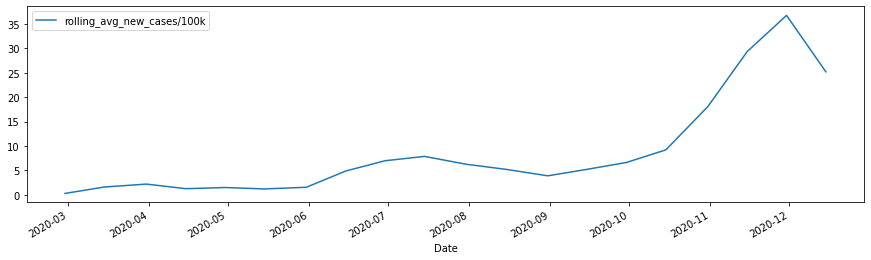

In [ ]:
df_washington_county[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))


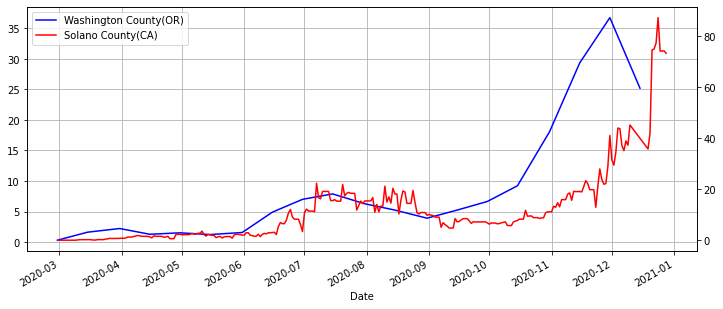

In [ ]:
plt.figure(figsize=(12,5))
plt.xlabel('Number of requests every 10 minutes')

ax1 = df_washington_county["rolling_avg_new_cases/100k"].plot(color='blue', grid=True, label='Washington County(OR)')
ax2 = df_solano_county["rolling_avg_new_cases/100k"].plot(color='red', grid=True, secondary_y=True, label='Solano County(CA)')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

In [ ]:
df_washington_county_minimal = df_washington_county[df_washington_county['growth_label'] == 'minimal']
df_washington_county_nc = df_washington_county[df_washington_county['growth_label'] == 'nochange']
df_washington_county_widespread = df_washington_county[df_washington_county['growth_label'] == 'widespread']

In [ ]:
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'

OR_labeled = pd.read_csv(location+'OR_SuperData_With_SimilarityScore_Mar04.csv',low_memory=False)
OR_labeled.head(5)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate,growth_label,similiary_score
0,2020-02-29,Oregon,41031.0,0.000000,Jefferson County,0.0,9.719966,92.366460,12.571429,8.857143,0.0,2.785714,0.285714,-0.928571,5.013675,Oregon,OR,41031.0,Jefferson County,41.0,20.571429,20.071429,3.756429,30.650000,1.528571,40.892857,0.534286,3.220714,0.000000,24192.0,10.514286,1.08,26.0,50339.0,0.9,20.0,51.89,4.0,102.0,2.2,0.2,0.024,0.000000,0.002143,43.500000,48.812683,5.992857,0.035714,0.025714,0.214286,0.000000,0.061429,0.000000,1.000000,3.300000,7.250000,0.600000,0.000000,0.000000,0.433903,0.000000,nochange,"(301, array([[0.99477784]]))"
1,2020-03-15,Oregon,41031.0,0.000000,Jefferson County,0.0,4.678473,39.923913,-23.750000,4.187500,0.0,-6.500000,-27.750000,0.000000,5.013675,Oregon,OR,41031.0,Jefferson County,41.0,32.812500,25.000000,3.389375,27.618750,1.418750,34.625000,0.463750,2.923750,0.000000,24192.0,0.325000,1.08,26.0,50339.0,0.9,20.0,51.89,4.0,102.0,2.2,0.2,0.024,0.000000,0.055000,58.500000,49.306294,5.418750,1.125000,1.244375,9.562500,0.812500,0.046250,3.062500,8.468750,6.643750,23.131250,0.600000,3.675000,0.000000,0.000000,0.000000,nochange,"(13669, array([[0.98887557]]))"
2,2020-03-31,Oregon,41031.0,0.066667,Jefferson County,0.0,2.951667,25.124638,-13.533333,1.266667,0.0,-7.466667,-38.000000,0.000000,5.013675,Oregon,OR,41031.0,Jefferson County,41.0,36.333333,26.000000,3.308000,27.266667,1.240000,30.706667,0.456667,2.852000,0.066667,24192.0,-2.133333,1.08,26.0,50339.0,0.9,20.0,51.89,4.0,102.0,2.2,0.2,0.024,0.000920,0.264000,68.600000,50.132514,5.160000,5.416667,5.640667,25.933333,3.600000,0.060667,18.200000,11.873333,13.086667,26.306667,0.226667,12.996000,0.275573,0.239629,0.000017,nochange,"(2570, array([[0.9737712]]))"
3,2020-04-15,Oregon,41031.0,0.642857,Jefferson County,0.0,3.944196,34.096273,0.000000,0.000000,0.0,0.714286,-36.214286,0.000000,5.013675,Oregon,OR,41031.0,Jefferson County,41.0,27.214286,23.071429,3.475714,31.607143,1.542857,36.592857,0.430000,3.046429,0.642857,24192.0,4.535714,1.08,26.0,50339.0,0.9,20.0,51.89,4.0,102.0,2.2,0.2,0.024,0.020671,0.420714,0.714286,50.062779,4.814286,10.334286,8.497143,25.785714,7.285714,0.092857,33.500000,10.242857,14.614286,28.185714,0.200000,20.927857,2.657313,2.541778,0.000200,nochange,"(2590, array([[0.9860505]]))"
4,2020-04-30,Oregon,41031.0,0.933333,Jefferson County,0.0,5.828539,52.971014,-0.533333,0.000000,0.0,4.000000,-34.666667,0.000000,5.013675,Oregon,OR,41031.0,Jefferson County,41.0,23.000000,20.733333,3.489333,35.166667,1.833333,40.080000,0.386667,3.102000,0.933333,24192.0,6.433333,1.08,26.0,50339.0,0.9,20.0,51.89,4.0,102.0,2.2,0.2,0.024,0.045927,0.422000,0.266667,49.811245,4.266667,16.700667,5.338000,20.600000,8.266667,0.154667,48.066667,7.473333,14.186667,29.866667,0.200000

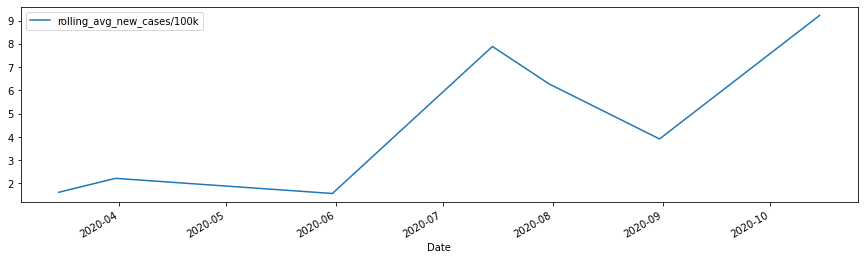

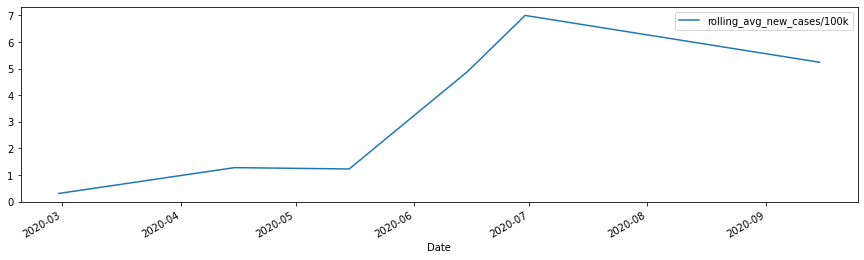

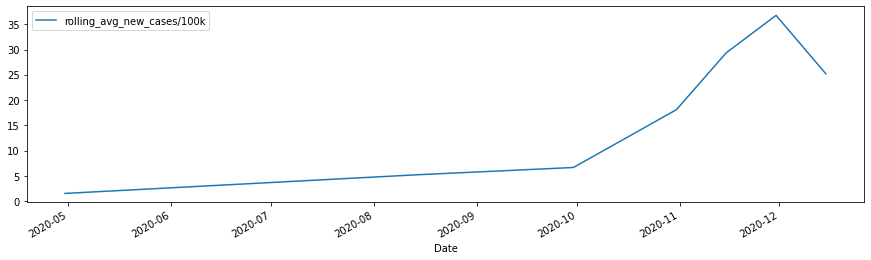

In [ ]:
#df_washington_county.plot(figsize=(15,4))
#df_washington_county.plot(subplots=True, figsize=(15,6))
#df_washington_county_minimal.plot(y=["rolling_avg_new_cases/100k"], figsize=(15,4))
#df_washington_county_nc.plot(y=["rolling_avg_new_cases/100k"], figsize=(15,4))
df_washington_county_minimal[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))
df_washington_county_nc[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))

df_washington_county_widespread[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))


#df.plot(x="R", y=["F10.7", "Dst"], style='.')

In [ ]:
df_Multnomah_County = or_bin_superset_data[or_bin_superset_data['County Name'] == 'Multnomah County']
df_Multnomah_County.head()

NameError: ignored

In [ ]:
df_Multnomah_County.index = pd.to_datetime(df_Multnomah_County["Date"])

df_Multnomah_County.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate,growth_label,similiary_score
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-29,2020-02-29,Oregon,41051.0,0.071429,Multnomah County,0.0,4.281643,84.857143,2.071429,7.285714,25.500,-2.5000,-1.285714,0.928571,715.275377,Oregon,OR,41051.0,Multnomah County,41.0,23.714286,24.214286,3.540000,32.857143,10.842857,35.478571,0.495000,3.042143,0.071429,811880.0,0.814286,11.61,18.0,64337.0,5.3,11.4,49.54,1180.0,185.0,2.2,0.2,0.024,0.000086,0.002143,29.642857,48.812683,5.992857,0.035714,0.025714,0.214286,4.357143,0.061429,0.0000,1.00000,3.30000,7.25000,0.6,0.000,0.008798,0.008798,0.000240,nochange,"(3407, [[0.984405556316313]])"
2020-03-15,2020-03-15,Oregon,41051.0,6.187500,Multnomah County,0.0,0.792187,15.250000,-46.625000,-10.687500,12.375,-46.0625,-41.937500,15.812500,715.275377,Oregon,OR,41051.0,Multnomah County,41.0,52.500000,38.000000,2.869375,29.387500,9.493750,25.856250,0.365625,2.504375,6.187500,811880.0,-16.981250,11.61,18.0,64337.0,5.3,11.4,49.54,1180.0,185.0,2.2,0.2,0.024,0.006900,0.055000,0.000000,49.306294,5.418750,1.125000,1.244375,9.562500,43.687500,0.046250,3.0625,8.46875,6.64375,23.13125,0.6,3.675,0.762120,0.481686,0.000613,minimal,"(8723, [[0.9665898295469391]])"


In [ ]:
df_Multnomah_County_minimal = df_Multnomah_County[df_Multnomah_County['growth_label'] == 'minimal']
df_Multnomah_County_nc = df_Multnomah_County[df_Multnomah_County['growth_label'] == 'nochange']
df_Multnomah_County_widespread = df_Multnomah_County[df_Multnomah_County['growth_label'] == 'widespread']

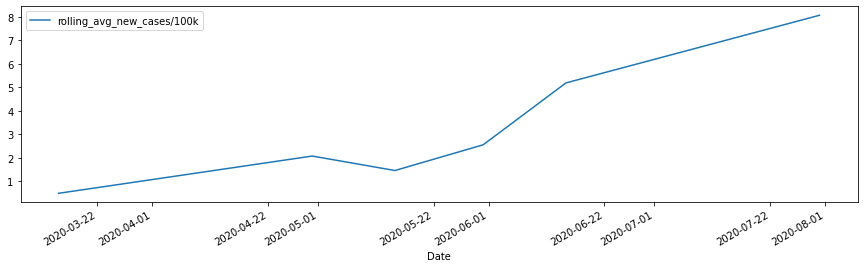

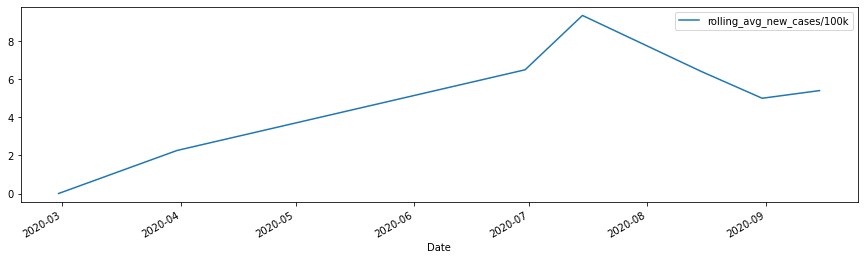

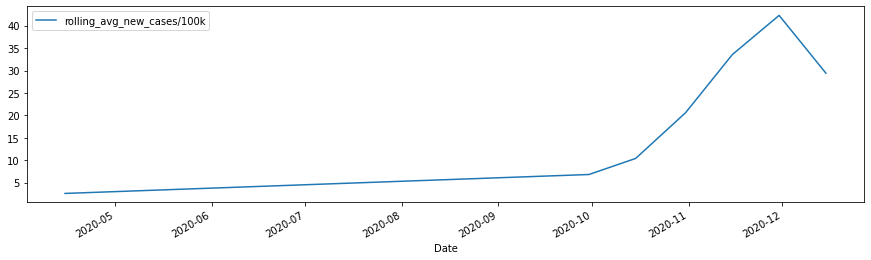

In [ ]:
df_Multnomah_County_minimal[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))
df_Multnomah_County_nc[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))

df_Multnomah_County_widespread[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))

# Getting growth_label in OR from CA [**unused**]

In [ ]:
print(len(or_bin_superset_data))
#select the first row 
print(or_bin_superset_data.iloc[0]['similiary_score'])

print("CA row number=",or_bin_superset_data.iloc[0]['similiary_score'][0])

print(or_bin_superset_data.iloc[0]['similiary_score'][1])

364
(10952, array([[0.99999075]]))
CA row number= 10952
[[0.99999075]]


In [ ]:
ca_labeled_superset_data.iloc[10952]['growth_label']

'minimal'

In [ ]:
for i in range(0,len(or_bin_superset_data)):
  #print(i)
  row = or_bin_superset_data.iloc[i]['similiary_score'][0]
  #print(row)
  or_bin_superset_data['growth_label'] = ca_labeled_superset_data.iloc[row]['growth_label']

In [ ]:
or_bin_superset_data.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,similiary_score,growth_label
0,2020-10-02,Oregon,41067,65,Washington County,10.0,21.121,107,-21.0,-7.0,0.0,-43.0,-43.0,13.0,310.164459,Oregon,OR,41067,Washington County,41,28,26,3.52,28.5,2.6,35.9,0.37,3.16,65,597695,6.2,6.13,18,78010,1.9,16.5,49.42,354,132,2.2,0.2,0.024,0.0736,1.68,0,50.99648,4.9,166.39,5.73,15,636,5.51,0,0.9,7.2,32.9,1.71,2.44,10.875112,6.286054,"(10952, [[0.9999907527813767]])",minimal
1,2020-10-02,Oregon,41067,65,Washington County,10.0,7.931,104,-21.0,-7.0,0.0,-43.0,-43.0,13.0,310.164459,Oregon,OR,41067,Washington County,41,28,26,3.52,28.5,2.6,35.9,0.37,3.16,65,597695,6.2,6.13,18,78010,1.9,16.5,49.42,354,132,2.2,0.2,0.024,0.0736,1.68,0,50.99648,4.9,166.39,5.73,15,636,5.51,0,0.9,7.2,32.9,1.71,2.44,10.875112,7.050897,"(10952, [[0.9999907971148785]])",minimal


In [ ]:
or_bin_superset_data['growth_label'].unique()

array(['minimal'], dtype=object)

In [ ]:
or_bin_superset_data[or_bin_superset_data['growth_label']=='widespread']

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,similiary_score,growth_label


# Option2:  KNN- Opposite- Add with CA- Not using now

https://towardsdatascience.com/knn-in-python-835643e2fb53

In [ ]:
ca_labeled_superset_data = ca_labeled_superset_data[ca_labeled_superset_data['growth_label']=='widespread']

In [ ]:
ca_labeled_superset_data_filtered = ca_labeled_superset_data[required_cols]

In [ ]:
or_bin_superset_data_filtered = or_bin_superset_data[required_cols]

In [ ]:
from scipy.spatial.distance import cosine

def key_consine_similarity(tupple):
    return tupple[1]

# This method computes the distance between each vectors with predicted_vectors input
# in our case, vectors is CA data , predicted_vectors is OR data

def get_computed_similarities_rev(vectors, predicted_vectors, reverse=False):
    data_size = len(vectors) # size of your CA data
    print("len of OR:", len(predicted_vectors)) #size of OR
    print("len of CA:", data_size)
    cosine_similarities = []

    for i in range(data_size): #CA
      max_cosine = -1
      max_j = 0
      for j in range(len(predicted_vectors)): #OR
        cosine_sim_val = (1 - cosine(vectors[i], predicted_vectors[j]))
        if max_cosine < cosine_sim_val:
            max_cosine = cosine_sim_val
            max_j = j
      cosine_similarities.append((max_j, max_cosine))
        #if cosine_sim_val > 0.5: # update threshold
          #continue
        
    print('len cosine_similarities : ',len(cosine_similarities))
    #return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)
    return cosine_similarities

def display_top_n(sorted_cosine_similarities, n=10):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        print('News Title: ', merged_data.iloc[index, 0])  
        print('News statement: ', merged_data.iloc[index, 1])  
        print('News label: ', merged_data.iloc[index, 4])  

        print('Cosine Sim Val :', consine_sim_val)
        print('---------------------------------')

In [ ]:
or_bin_superset_data_filtered.head(3)

,mask_rule_severity,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,rolling_avg_new_cases/100k
0,10.0,107,-21.0,-7.0,0.0,-43.0,-43.0,13.0,310.164459,28,26,3.52,28.5,2.6,35.9,0.37,3.16,6.2,6.13,18,78010,1.9,16.5,49.42,354,132,2.2,0.2,0,50.99648,4.9,166.39,5.73,15,636,5.51,0,0.9,7.2,32.9,1.71,2.44,6.286054
1,10.0,104,-21.0,-7.0,0.0,-43.0,-43.0,13.0,310.164459,28,26,3.52,28.5,2.6,35.9,0.37,3.16,6.2,6.13,18,78010,1.9,16.5,49.42,354,132,2.2,0.2,0,50.99648,4.9,166.39,5.73,15,636,5.51,0,0.9,7.2,32.9,1.71,2.44,7.050897
2,10.0,128,-21.0,-7.0,0.0,-43.0,-43.0,13.0,310.164459,28,26,3.52,28.5,2.6,35.9,0.37,3.16,6.2,6.13,18,78010,1.9,16.5,49.42,354,132,2.2,0.2,0,50.99648,4.9,166.39,5.73,15,636,5.51,0,0.9,7.2,32.9,1.71,2.44,7.815740


In [ ]:
print(or_bin_superset_data_filtered.shape)
print(ca_labeled_superset_data_filtered.shape)
or_bin_superset_data.shape

(364, 43)
(521, 43)


(364, 61)

In [ ]:
ca_labeled_superset_data_filtered['similiary_score_with_OR'] = get_computed_similarities_rev(vectors=ca_labeled_superset_data_filtered.values, predicted_vectors=or_bin_superset_data_filtered.values)

len of OR: 364
len of CA: 521
len cosine_similarities :  521


In [ ]:
ca_labeled_superset_data_filtered.head(4)

,mask_rule_severity,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,rolling_avg_new_cases/100k,similiary_score_with_OR
540,10.0,38,-6.0,-6.0,0.0,0.0,-22.0,8.0,24.565345,18,19,3.32,26.6,0.5,46.2,0.38,2.94,13.8,0.16,35,61198,2.0,13.6,53.67,20,147,2.05,0.22,0,65.511702,5.1,614.28,24.33,1104,202,23.08,259,3.3,10.6,38.1,1.71,2.13,71.096666,"(103, 0.9997803339022608)"
541,10.0,39,-7.0,-5.0,0.0,0.0,-23.0,8.0,24.565345,16,19,3.26,29.4,0.4,53.0,0.38,2.87,11.1,0.16,35,61198,2.0,13.6,53.67,20,147,2.05,0.22,0,66.029105,5.2,618.72,24.62,1163,233,24.74,259,3.3,10.6,38.1,1.71,2.00,92.860952,"(103, 0.9997628382121437)"
542,10.0,47,-9.0,-3.0,0.0,0.0,-22.0,8.0,24.565345,17,19,3.57,27.1,0.3,59.3,0.36,3.21,24.3,0.16,35,61198,2.0,13.6,53.67,20,147,2.05,0.22,0,66.583542,5.2,623.79,25.78,1222,270,26.08,259,3.3,10.6,38.1,1.71,1.91,113.174285,"(84, 0.9997440704629695)"
543,10.0,17,-5.0,0.0,0.0,0.0,-9.0,0.0,24.565345,26,24,2.99,39.2,1.1,58.8,0.24,2.75,6.5,0.16,35,61198,2.0,13.6,53.67,20,147,2.05,0.22,0,67.161747,5.3,629.52,25.98,1289,387,27.18,259,3.3,10.6,38.1,1.71,1.85,131.673927,"(243, 0.9997224799864756)"


In [ ]:
ca_labeled_superset_data_filtered.similiary_score_with_OR.unique()

array([(103, 0.9997803339022608), (103, 0.9997628382121437),
       (84, 0.9997440704629695), (243, 0.9997224799864756),
       (105, 0.999698764956809), (99, 0.9996752759502611),
       (89, 0.9996497500028938), (99, 0.9996256497014715),
       (105, 0.9995999284165753), (352, 0.9993017844854767),
       (240, 0.999261494109279), (352, 0.9992184815893761),
       (355, 0.9991713656367462), (352, 0.9991224079533975),
       (352, 0.9990681281400025), (352, 0.9990098206974501),
       (352, 0.9989479544034175), (352, 0.9988796444831441),
       (352, 0.9988093511629081), (87, 0.9999007625899466),
       (85, 0.9998986539457577), (87, 0.9998969439632971),
       (105, 0.9996486717963383), (96, 0.9995656033365777),
       (95, 0.9995356555653538), (243, 0.9991870096511825),
       (240, 0.9991398429340427), (242, 0.9990905766219971),
       (337, 0.999035983393285), (352, 0.998976702436995),
       (240, 0.9989142253977616), (268, 0.9988446002239827),
       (352, 0.9987757113144994), (35

In [ ]:
or_bin_superset_data.filter(like = '103', axis=0)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,similiary_score
103,2020-10-05,Oregon,41067,31,Washington County,10.0,2.926,50,-18.0,-10.0,22.0,-49.0,-44.0,14.0,310.164459,Oregon,OR,41067,Washington County,41,43,31,3.22,25.9,2.0,26.5,0.41,2.81,31,597695,-5.6,6.13,18,78010,1.9,16.5,49.42,354,132,2.2,0.2,0.024,0.0541,1.7,0,51.085148,4.9,169.19,5.13,15,470,5.69,0,1.0,6.9,32.6,1.71,2.4,5.186592,5.186592,"(10952, 0.9999878090813492)"


In [ ]:
or_bin_superset_data.filter(like = '84', axis=0)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,similiary_score
84,2020-10-05,Oregon,41067,31,Washington County,10.0,12.828,65,-18.0,-10.0,22.0,-49.0,-44.0,14.0,310.164459,Oregon,OR,41067,Washington County,41,43,31,3.22,25.9,2.0,26.5,0.41,2.81,31,597695,-5.6,6.13,18,78010,1.9,16.5,49.42,354,132,2.2,0.2,0.024,0.0541,1.7,0,51.085148,4.9,169.19,5.13,15,470,5.69,0,1.0,6.9,32.6,1.71,2.40,5.186592,5.473408,"(10952, 0.9999877045172133)"
184,2020-10-09,Oregon,41067,35,Washington County,10.0,4.027,27,-20.0,-8.0,0.0,-47.0,-44.0,13.0,310.164459,Oregon,OR,41067,Washington County,41,46,26,3.06,30.4,3.2,33.7,0.37,2.69,35,597695,-9.6,6.13,18,78010,1.9,16.5,49.42,354,132,2.2,0.2,0.024,0.0647,1.9,1,51.338100,5.0,174.35,5.85,16,670,5.92,7,1.0,6.9,32.6,1.71,2.41,5.855829,5.855829,"(10952, 0.9999919192925663)"
284,2020-10-13,Oregon,41067,46,Washington County,10.0,4.210,179,-24.0,-8.0,-4.0,-54.0,-45.0,16.0,310.164459,Oregon,OR,41067,Washington County,41,33,27,3.45,27.2,2.6,30.4,0.41,3.04,46,597695,2.2,6.13,18,78010,1.9,16.5,49.42,354,132,2.2,0.2,0.024,0.0792,2.0,0,51.368106,5.0,179.27,5.61,16,650,6.10,14,1.1,6.7,32.5,1.71,2.37,7.696233,7.122601,"(10952, 0.9999898742320167)"


In [ ]:
or_bin_superset_data.filter(like = '243', axis=0)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,similiary_score
243,2020-10-11,Oregon,41067,62,Washington County,10.0,1.412,24,-24.0,-14.0,-45.0,-50.0,-11.0,6.0,310.164459,Oregon,OR,41067,Washington County,41,41,33,3.42,24.6,2.4,38.7,0.19,3.22,62,597695,8.2,6.13,18,78010,1.9,16.5,49.42,354,132,2.2,0.2,0.024,0.0809,1.99,0,51.406607,5.0,176.88,5.85,17,614,6.03,7,1.1,6.7,32.5,1.71,2.37,10.373184,10.373184,"(10952, 0.9999914069356016)"


In [ ]:
or_bin_superset_data.filter(like = '105', axis=0)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,similiary_score
105,2020-10-05,Oregon,41067,31,Washington County,10.0,3.963,37,-18.0,-10.0,22.0,-49.0,-44.0,14.0,310.164459,Oregon,OR,41067,Washington County,41,43,31,3.22,25.9,2.0,26.5,0.41,2.81,31,597695,-5.6,6.13,18,78010,1.9,16.5,49.42,354,132,2.2,0.2,0.024,0.0541,1.7,0,51.085148,4.9,169.19,5.13,15,470,5.69,0,1.0,6.9,32.6,1.71,2.4,5.186592,5.186592,"(10952, 0.999987869778439)"


In [ ]:
or_bin_superset_data.filter(like = '324', axis=0)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,similiary_score
324,2020-10-14,Oregon,41067,50,Washington County,10.0,6.61,44,-18.0,-9.0,31.0,-52.0,-43.0,15.0,310.164459,Oregon,OR,41067,Washington County,41,41,28,2.7,32.3,3.5,32.0,0.41,2.29,50,597695,-23.0,6.13,18,78010,1.9,16.5,49.42,354,132,2.2,0.2,0.024,0.0725,2.09,0,51.327364,5.0,181.72,5.97,16,713,6.15,14,1.1,6.7,32.5,1.71,2.36,8.365471,8.365471,"(10952, 0.9999919255715619)"


In [ ]:
#sorted_cosine_similarities = get_computed_similarities(vectors=CA_data.values, predicted_vectors=OR_data.values)
#display_top_n(sorted_cosine_similarities=sorted_cosine_similarities)

In [ ]:
or_bin_superset_data_filtered

# Conclusion, Details, and Observation

* I have fixed the and changed the logic of cosine similarity code
* There are two options, I have followed to compute the similarity score for Oregon

> 1. **Option1:** A= Oregon , B= CA ; Outer loop= OR, Inner Loop= CA
>> * I have taken Oregon data and all the labeled CA data
>> * Then I have compared each row of Oregon with all the rows of CA labeled data. I cann't filter here the 'superspread' CA labeled data, because then OR data will be forcefully tagged as 'superspread'.
>> * I have stored the similarity score and the CA dataframe's row number pair in Oregon dataframe. 
>> * So now each row of Oregon dataset has the similarity score with the matching row number of CA dataframe.

> **2. Option2:** A= CA-Superspread B= Oregon ,  ; Outer loop= CA-Superspread, Inner Loop= OR
>> * This is opposite of option-1 and I think this the is the best way.
>> * Here I have filtered the 'superspread' data of CA labeled data
>> * Then I have compared the 'superspread' CA data with each rows of Oregon data to compute the cosine similarity
>> * Final output, for each row in 'superspread' CA data, I am storing the matching/ high similarity row number from Oregon dataset.
>> * Here we have to analize less number of data and only the superspread data
>> * I have analized few rows and found 'Washington County' of Oregon as a superspread county and high similarity with CA superspread data. This is matching with current situation also.

# Our old code for KNN Classifier

In [ ]:
# KNN classifier

seed = 58

# perform the split which gets us the train data and the test data
X_train, y_train, X_test, y_test = train_test_split(CA_superset_data_filtered, labels,
                                                                    test_size=0.25,
                                                                    random_state=seed,
                                                                    stratify=labels)
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
                           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
                           weights='distance')

knn.fit(X_train, y_train)
labels_pred = knn.predict(X_test)


## Jeyasri's code ( for Reference)

In [ ]:
from scipy.spatial.distance import cosine

def key_consine_similarity(tupple):
    return tupple[1]

# This method computes the distance between each vectors with predicted_vectors input
# in our case, vectors is CA data , predicted_vectors is OR data

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(vectors) # size of your CA data
    cosine_similarities = []

    for i in range(len(predicted_vectors)):
      for j in range(data):
        cosine_sim_val = (1 - cosine(vectors[j], predicted_vectors[i]))
        cosine_similarities.append((i, cosine_sim_val))
        if cosine_sim_val > 0.5: # update threshold
          continue
        
    print('len cosine_similarities : ',len(cosine_similarities))
    return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)

def display_top_n(sorted_cosine_similarities, n=10):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        print('News Title: ', merged_data.iloc[index, 0])  
        print('News statement: ', merged_data.iloc[index, 1])  
        print('News label: ', merged_data.iloc[index, 4])  

        print('Cosine Sim Val :', consine_sim_val)
        print('---------------------------------')

In [ ]:
df['similiary_score'] = get_computed_similarities()

In [ ]:
sorted_cosine_similarities = get_computed_similarities(vectors=CA_data.values, predicted_vectors=OR_data.values)
display_top_n(sorted_cosine_similarities=sorted_cosine_similarities)